# 2. Data Preprocessing and Model Training - Plank

**Objective:**
1. Define a robust feature extraction process using `GeometryUtils`.
2. Process the raw train/test data into feature matrices (X) and target vectors (y).
3. Create `scikit-learn` pipelines that bundle imputation, scaling, and modeling.
4. Train and evaluate a variety of classification models (LR, KNN, RF, XGB, etc.).
5. Compare model performance and visualize the results.
6. Save all trained model pipelines and a user-selected best model to `.pkl` files.

In [2]:
import pandas as pd
import numpy as np
import pickle
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.geometry_utils import GeometryUtils

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2.1 Define Paths and Constants

In [3]:
BASE_DATA_PATH = "../data/"
TRAIN_RAW_PATH = os.path.join(BASE_DATA_PATH, "train.csv")
TEST_RAW_PATH = os.path.join(BASE_DATA_PATH, "test.csv")

MODEL_PKL_DIR = "../models/pkl/"
os.makedirs(MODEL_PKL_DIR, exist_ok=True)

VISIBILITY_THRESHOLD = 0.4
RANDOM_STATE = 42

LANDMARK_NAMES = [
    'nose', 'left_eye_inner', 'left_eye', 'left_eye_outer', 'right_eye_inner', 'right_eye', 'right_eye_outer',
    'left_ear', 'right_ear', 'mouth_left', 'mouth_right', 'left_shoulder', 'right_shoulder', 'left_elbow',
    'right_elbow', 'left_wrist', 'right_wrist', 'left_pinky', 'right_pinky', 'left_index', 'right_index',
    'left_thumb', 'right_thumb', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle',
    'right_ankle', 'left_heel', 'right_heel', 'left_foot_index', 'right_foot_index'
]

FEATURE_COLUMN_NAMES = [
    'left_elbow_angle', 'right_elbow_angle',
    'left_shoulder_angle', 'right_shoulder_angle',
    'left_hip_angle', 'right_hip_angle',
    'left_knee_angle', 'right_knee_angle',
    'left_body_align_angle', 'right_body_align_angle', 
    'left_hip_deviation', 'right_hip_deviation', 
    'shoulder_hip_y_diff_left', 'shoulder_hip_y_diff_right',
    'hip_ankle_y_diff_left', 'hip_ankle_y_diff_right',
    'torso_length_left', 'torso_length_right',
    'leg_length_left', 'leg_length_right'
]

## 2.2 Feature Extraction

In [4]:
geo_utils = GeometryUtils()

def extract_features_from_row(row, landmark_names, visibility_threshold):
    lm_coords = {}
    for name in landmark_names:
        x = row.get(f'{name}_x', np.nan)
        y = row.get(f'{name}_y', np.nan)
        v = row.get(f'{name}_v', 0)
        if v > visibility_threshold:
            lm_coords[name] = [x, y]
        else:
            lm_coords[name] = [np.nan, np.nan]

    def get_coord(name): return lm_coords.get(name, [np.nan, np.nan])

    features = []
    # Angles
    features.append(geo_utils.calculate_angle(get_coord('left_shoulder'), get_coord('left_elbow'), get_coord('left_wrist')))
    features.append(geo_utils.calculate_angle(get_coord('right_shoulder'), get_coord('right_elbow'), get_coord('right_wrist')))
    features.append(geo_utils.calculate_angle(get_coord('left_elbow'), get_coord('left_shoulder'), get_coord('left_hip')))
    features.append(geo_utils.calculate_angle(get_coord('right_elbow'), get_coord('right_shoulder'), get_coord('right_hip')))
    features.append(geo_utils.calculate_angle(get_coord('left_shoulder'), get_coord('left_hip'), get_coord('left_knee')))
    features.append(geo_utils.calculate_angle(get_coord('right_shoulder'), get_coord('right_hip'), get_coord('right_knee')))
    features.append(geo_utils.calculate_angle(get_coord('left_hip'), get_coord('left_knee'), get_coord('left_ankle')))
    features.append(geo_utils.calculate_angle(get_coord('right_hip'), get_coord('right_knee'), get_coord('right_ankle')))
    # Body alignment
    features.append(geo_utils.calculate_angle(get_coord('left_shoulder'), get_coord('left_hip'), get_coord('left_ankle')))
    features.append(geo_utils.calculate_angle(get_coord('right_shoulder'), get_coord('right_hip'), get_coord('right_ankle')))
    # Hip deviation
    features.append(geo_utils.distance_point_to_line(get_coord('left_hip'), get_coord('left_shoulder'), get_coord('left_knee')))
    features.append(geo_utils.distance_point_to_line(get_coord('right_hip'), get_coord('right_shoulder'), get_coord('right_knee')))
    # Vertical differences
    features.append(abs(get_coord('left_shoulder')[1] - get_coord('left_hip')[1]))
    features.append(abs(get_coord('right_shoulder')[1] - get_coord('right_hip')[1]))
    features.append(abs(get_coord('left_hip')[1] - get_coord('left_ankle')[1]))
    features.append(abs(get_coord('right_hip')[1] - get_coord('right_ankle')[1]))
    # Segment lengths
    features.append(geo_utils.calculate_distance(get_coord('left_shoulder'), get_coord('left_hip')))
    features.append(geo_utils.calculate_distance(get_coord('right_shoulder'), get_coord('right_hip')))
    features.append(geo_utils.calculate_distance(get_coord('left_hip'), get_coord('left_ankle')))
    features.append(geo_utils.calculate_distance(get_coord('right_hip'), get_coord('right_ankle')))
    return features

def process_raw_data_to_features(df_raw):
    feature_data = df_raw.apply(lambda row: extract_features_from_row(row, LANDMARK_NAMES, VISIBILITY_THRESHOLD), axis=1, result_type='expand')
    feature_data.columns = FEATURE_COLUMN_NAMES
    
    # Combine with labels
    df_features = pd.concat([df_raw['label'], feature_data], axis=1)
    
    # Map labels to numeric
    label_map = {"C": 0, "H": 1, "L": 2} # Correct, Hips High, Hips Low
    df_features['label'] = df_features['label'].map(label_map)
    
    # Drop rows where label mapping failed or all features are NaN
    df_features.dropna(subset=['label'], inplace=True)
    df_features.dropna(how='all', subset=FEATURE_COLUMN_NAMES, inplace=True)
    df_features['label'] = df_features['label'].astype(int)
    
    return df_features

## 2.3 Load and Process Data

In [5]:
df_raw_train = pd.read_csv(TRAIN_RAW_PATH)
df_raw_test = pd.read_csv(TEST_RAW_PATH)

print("Processing training data...")
df_train = process_raw_data_to_features(df_raw_train)
print("Processing testing data...")
df_test = process_raw_data_to_features(df_raw_test)

X_train = df_train.drop('label', axis=1)
y_train = df_train['label']
X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

print(f"Training set: X shape {X_train.shape}, y shape {y_train.shape}")
print(f"Test set: X shape {X_test.shape}, y shape {y_test.shape}")
print("\nFeatures extracted. Sample:")
display(X_train.head())

Processing training data...
Processing testing data...
Training set: X shape (28520, 20), y shape (28520,)
Test set: X shape (710, 20), y shape (710,)

Features extracted. Sample:


,left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_hip_angle,right_hip_angle,left_knee_angle,right_knee_angle,left_body_align_angle,right_body_align_angle,left_hip_deviation,right_hip_deviation,shoulder_hip_y_diff_left,shoulder_hip_y_diff_right,hip_ankle_y_diff_left,hip_ankle_y_diff_right,torso_length_left,torso_length_right,leg_length_left,leg_length_right
0,NaN,92.384308,NaN,91.242573,NaN,169.201567,NaN,178.354347,167.202022,168.374992,NaN,0.019536,0.003445,0.006737,0.076993,0.066979,0.219382,0.223328,0.373434,0.389720
1,NaN,92.421566,NaN,91.226716,NaN,169.245161,NaN,178.320609,167.209867,168.401807,NaN,0.019461,0.003411,0.006665,0.076967,0.066920,0.219411,0.223386,0.373275,0.389681
2,NaN,92.451142,NaN,91.221631,NaN,169.266800,NaN,178.297291,167.213245,168.411928,NaN,0.019425,0.003397,0.006636,0.076955,0.066901,0.219448,0.223419,0.373205,0.389667
3,NaN,92.475792,NaN,91.212310,NaN,169.297482,NaN,178.268606,167.219388,168.428534,NaN,0.019375,0.003375,0.006592,0.076938,0.066867,0.219472,0.223442,0.373129,0.389664
4,NaN,92.499513,NaN,91.209926,NaN,169.318402,NaN,178.247564,167.223595,168.439052,NaN,0.019340,0.003358,0.006571,0.076924,0.066833,0.219486,0.223466,0.373054,0.389657


## 2.4 Define Model Pipelines

In [6]:
pipelines = {
    "LR": Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000))
    ]),
    "KNN": Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier(n_neighbors=7))
    ]),
    "DT": Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        # ('scaler', StandardScaler()), # DTs are not sensitive to feature scaling
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
    ]),
    "RF": Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        # ('scaler', StandardScaler()), # RFs are not sensitive to feature scaling
        ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_estimators=100))
    ]),
    "XGB": Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='mlogloss'))
    ])
}
print(f"Defined {len(pipelines)} model pipelines.")

Defined 5 model pipelines.


## 2.5 Train and Evaluate Models

In [7]:
trained_pipelines = {}
evaluation_results = []
label_names = ['Correct (0)', 'Hips High (1)', 'Hips Low (2)']

for name, pipeline in pipelines.items():
    print(f"--- Training {name} ---")
    pipeline.fit(X_train, y_train)
    trained_pipelines[name] = pipeline
    
    # Evaluate
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    evaluation_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1-Score (Weighted)": f1,
        "Confusion Matrix": cm
    })
    print(f"{name} - Test Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

# Display results in a DataFrame
results_df = pd.DataFrame(evaluation_results).sort_values(by='F1-Score (Weighted)', ascending=False).reset_index(drop=True)
print("\n--- Model Evaluation Summary ---")
display(results_df[['Model', 'Accuracy', 'F1-Score (Weighted)']])

--- Training LR ---
LR - Test Accuracy: 0.9915, F1-Score: 0.9916
--- Training KNN ---
KNN - Test Accuracy: 0.9930, F1-Score: 0.9930
--- Training DT ---
DT - Test Accuracy: 0.9845, F1-Score: 0.9845
--- Training RF ---
RF - Test Accuracy: 0.9958, F1-Score: 0.9958
--- Training XGB ---
XGB - Test Accuracy: 0.9958, F1-Score: 0.9958

--- Model Evaluation Summary ---


,Model,Accuracy,F1-Score (Weighted)
0,RF,0.995775,0.995781
1,XGB,0.995775,0.995781
2,KNN,0.992958,0.992969
3,LR,0.991549,0.991573
4,DT,0.984507,0.984502


### Performance Visualization

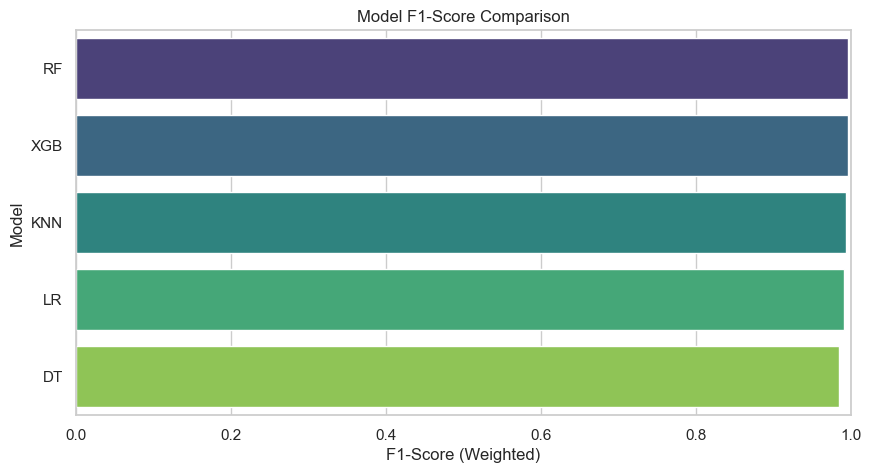

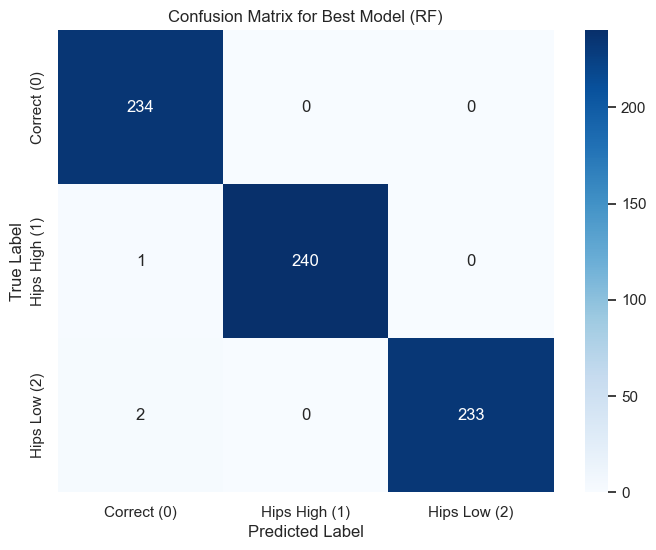

In [8]:
# F1-Score Comparison Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='F1-Score (Weighted)', y='Model', palette='viridis')
plt.title('Model F1-Score Comparison')
plt.xlim(0, 1)
plt.show()

# Confusion Matrix for the Best Model
best_model_name = results_df.iloc[0]['Model']
best_cm = results_df.iloc[0]['Confusion Matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names)
plt.title(f'Confusion Matrix for Best Model ({best_model_name})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 2.6 Save Models

All trained pipelines saved to: ../models/pkl/all_trained_model.pkl


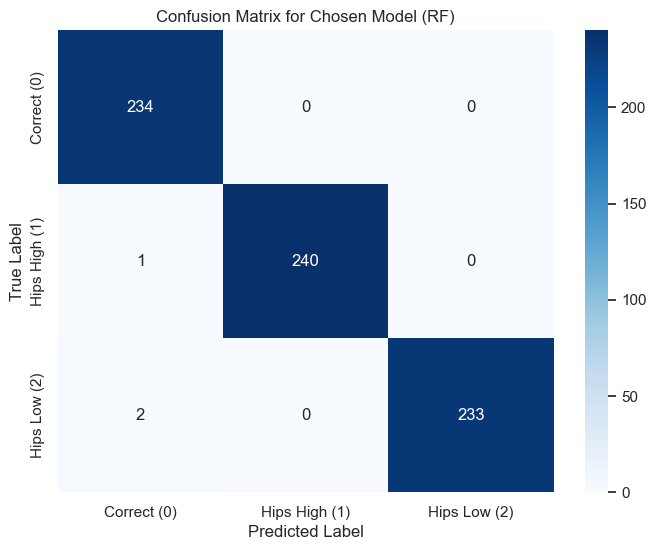

Chosen model 'RF' saved to: ../models/pkl/RF_model.pkl


In [ ]:
# 1. Save all trained pipelines into one file
all_models_path = os.path.join(MODEL_PKL_DIR, 'all_trained_model.pkl')
with open(all_models_path, 'wb') as f:
    pickle.dump(trained_pipelines, f)
print(f"All trained pipelines saved to: {all_models_path}")

# 2. Choose and save a specific model for deployment
#    >>>>> YOU CAN CHANGE THIS VALUE TO 'LR', 'KNN', 'DT', 'RF', or 'XGB' <<<<<
CHOSEN_MODEL_KEY = 'RF' 

if CHOSEN_MODEL_KEY in trained_pipelines:
    # Display Confusion Matrix for the chosen model
    chosen_model_cm_row = results_df[results_df['Model'] == CHOSEN_MODEL_KEY]
    if not chosen_model_cm_row.empty:
        chosen_model_cm = chosen_model_cm_row.iloc[0]['Confusion Matrix']
        plt.figure(figsize=(8, 6))
        sns.heatmap(chosen_model_cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_names, yticklabels=label_names)
        plt.title(f'Confusion Matrix for Chosen Model ({CHOSEN_MODEL_KEY})')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    else:
        print(f"Could not find evaluation results for model '{CHOSEN_MODEL_KEY}' to display confusion matrix.")

    chosen_model_pipeline = trained_pipelines[CHOSEN_MODEL_KEY]
    chosen_model_path = os.path.join(MODEL_PKL_DIR, f'{CHOSEN_MODEL_KEY}_model.pkl')
    with open(chosen_model_path, 'wb') as f:
        pickle.dump(chosen_model_pipeline, f)
    print(f"Chosen model '{CHOSEN_MODEL_KEY}' saved to: {chosen_model_path}")
else:
    print(f"Error: Chosen model key '{CHOSEN_MODEL_KEY}' not found in trained pipelines. Available keys: {list(trained_pipelines.keys())}")